# Receding Horizon

This notebook is your playground to pull together techniques from the previous lessons! A solution here can be built from previous solutions (more or less) so we will offer no solution notebook this time.

Here's a suggested approach:

1. Load the colliders data
2. Discretize your search space into a grid or graph
3. Define a start and goal location
4. Find a coarse 2D plan from start to goal
5. Choose a location along that plan and discretize
   a local volume around that location (for example, you
   might try a 40x40 m area that is 10 m high discretized
   into 1m^3 voxels)
6. Define your goal in the local volume to a a node or voxel
   at the edge of the volume in the direction of the next
   waypoint in your coarse global plan.
7. Plan a path through your 3D grid or graph to that node
   or voxel at the edge of the local volume.  

We'll import some of the routines from previous exercises that you might find useful here.  

In [41]:
import numpy as np
import matplotlib.pyplot as plt

import sys
get_ipython().system('{sys.executable} -m pip install -I networkx==2.1')
import pkg_resources
pkg_resources.require("networkx==2.1")
import networkx as nx

# Grid creation routine
from grid import create_grid
# Voxel map creation routine
from voxmap import create_voxmap
# 2D A* planning routine (can you convert to 3D??)
from planning import a_star
# Random sampling routine
from sampling import Sampler
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue


%matplotlib inline

  Using cached https://files.pythonhosted.org/packages/ed/1b/72a1821152d07cf1d8b6fce298aeb06a7eb90f4d6d41acec9861e7cc6df0/decorator-4.4.2-py2.py3-none-any.whl
scikit-image 0.14.2 has requirement dask[array]>=1.0.0, but you'll have dask 0.16.1 which is incompatible.
pomegranate 0.9.0 has requirement networkx<2.0,>=1.8.1, but you'll have networkx 2.1 which is incompatible.
moviepy 0.2.3.2 has requirement decorator==4.0.11, but you'll have decorator 4.4.2 which is incompatible.
jupyterlab-server 1.0.0 has requirement jsonschema>=3.0.1, but you'll have jsonschema 2.6.0 which is incompatible.
ipywidgets 7.0.5 has requirement widgetsnbextension~=3.0.0, but you'll have widgetsnbextension 3.1.0 which is incompatible.


In [49]:
plt.rcParams['figure.figsize'] = 16, 16

## Load Data

In [4]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ..., 
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [35]:
# flight_altitude = 3
safety_distance = 3

sampler = Sampler(data)
polygons = sampler._polygons


# Example: sampling 100 points and removing
# ones conflicting with obstacles.
nodes = sampler.sample(500)
print(len(nodes))


336


In [36]:
import numpy.linalg as LA
from sklearn.neighbors import KDTree

def can_connect(n1, n2):
    l = LineString([n1, n2])
    for p in polygons:
        if p.crosses(l) and p.height >= min(n1[2], n2[2]):
            return False
    return True

def create_graph(nodes, k):
    g = nx.Graph()
    tree = KDTree(nodes)
    for n1 in nodes:
        # for each node connect try to connect to k nearest nodes
        idxs = tree.query([n1], k, return_distance=False)[0]
        
        for idx in idxs:
            n2 = nodes[idx]
            if n2 == n1:
                continue
                
            if can_connect(n1, n2):
                g.add_edge(n1, n2, weight=1)
    return g

import time
t0 = time.time()
g = create_graph(nodes, 10)
print('graph took {0} seconds to build'.format(time.time()-t0))
print("Number of edges", len(g.edges))


graph took 63.824129581451416 seconds to build
Number of edges 1019


In [44]:
grid = create_grid(data, sampler._zmax, safety_distance)

fig = plt.figure()

# plt.imshow(grid, cmap='Greys', origin='lower')

# nmin = np.min(data[:, 0])
# emin = np.min(data[:, 1])

# # draw edges
# for (n1, n2) in g.edges:
#     plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'yellow' , alpha=0.5)

# # draw all nodes
# for n1 in nodes:
#     plt.scatter(n1[1] - emin, n1[0] - nmin, c='blue')
    
# # draw connected nodes
# for n1 in g.nodes:
#     plt.scatter(n1[1] - emin, n1[0] - nmin, c='yellow')

    
# # start and goal

# start_ne = (750., 23.)
# goal_ne = (70., 700.)

# plt.plot(start_ne[1], start_ne[0], 'x')
# plt.plot(goal_ne[1], goal_ne[0], 'x')

# plt.xlabel('NORTH')
# plt.ylabel('EAST')

# fig.tight_layout()
# plt.show()

In [42]:
def heuristic(n1, n2):
    # TODO: finish
    return LA.norm(np.array(n2) - np.array(n1))


# ## Step 6 - Complete A*

# In[ ]:


def a_star(graph, heuristic, start, goal):
    """Modified A* to work with NetworkX graphs."""
    
    # TODO: complete

    path = []
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_cost = item[0]
        current_node = item[1]

        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for next_node in graph[current_node]:
                cost = graph.edges[current_node, next_node]['weight']
                new_cost = current_cost + cost + heuristic(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    queue.put((new_cost, next_node))
                    
                    branch[next_node] = (new_cost, current_node)
             
    path = []
    path_cost = 0
    if found:
        
        # retrace steps
        path = []
        n = goal
        path_cost = branch[n][0]
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
            
    return path[::-1], path_cost


start = list(g.nodes)[0]
k = np.random.randint(len(g.nodes))
print(k, len(g.nodes))
goal = list(g.nodes)[k]


path, cost = a_star(g, heuristic, start, goal)
print(len(path), path)

256 319
Found a path.
11 [(316.50762708410849, 470.59843790794173, 18.131810068082277), (308.72403024240083, 392.64111017892469, 0.12358437250943322), (320.43077829187695, 378.06031037089667, 14.247015856431291), (296.80904799924093, 274.06258871021168, 14.937440937662977), (212.36866160491951, 216.29761634165845, 19.46295742629038), (179.14667433030786, 190.31574086676653, 17.185392273025588), (140.59109782478743, 113.84342213489094, 8.4908194857199604), (68.277078614327934, 87.512924288428167, 8.1448812370251655), (49.123210649402324, 26.80378711254474, 6.1636177495534188), (79.262591479394189, -16.74835703885941, 18.900214393543713), (107.3132728082989, -52.093391317111696, 11.005421114511975)]


(316.50762708410849, 470.59843790794173, 18.131810068082277) (308.72403024240083, 392.64111017892469, 0.12358437250943322)
(308.72403024240083, 392.64111017892469, 0.12358437250943322) (320.43077829187695, 378.06031037089667, 14.247015856431291)
(320.43077829187695, 378.06031037089667, 14.247015856431291) (296.80904799924093, 274.06258871021168, 14.937440937662977)
(296.80904799924093, 274.06258871021168, 14.937440937662977) (212.36866160491951, 216.29761634165845, 19.46295742629038)
(212.36866160491951, 216.29761634165845, 19.46295742629038) (179.14667433030786, 190.31574086676653, 17.185392273025588)
(179.14667433030786, 190.31574086676653, 17.185392273025588) (140.59109782478743, 113.84342213489094, 8.4908194857199604)
(140.59109782478743, 113.84342213489094, 8.4908194857199604) (68.277078614327934, 87.512924288428167, 8.1448812370251655)
(68.277078614327934, 87.512924288428167, 8.1448812370251655) (49.123210649402324, 26.80378711254474, 6.1636177495534188)
(49.123210649402324, 26.8

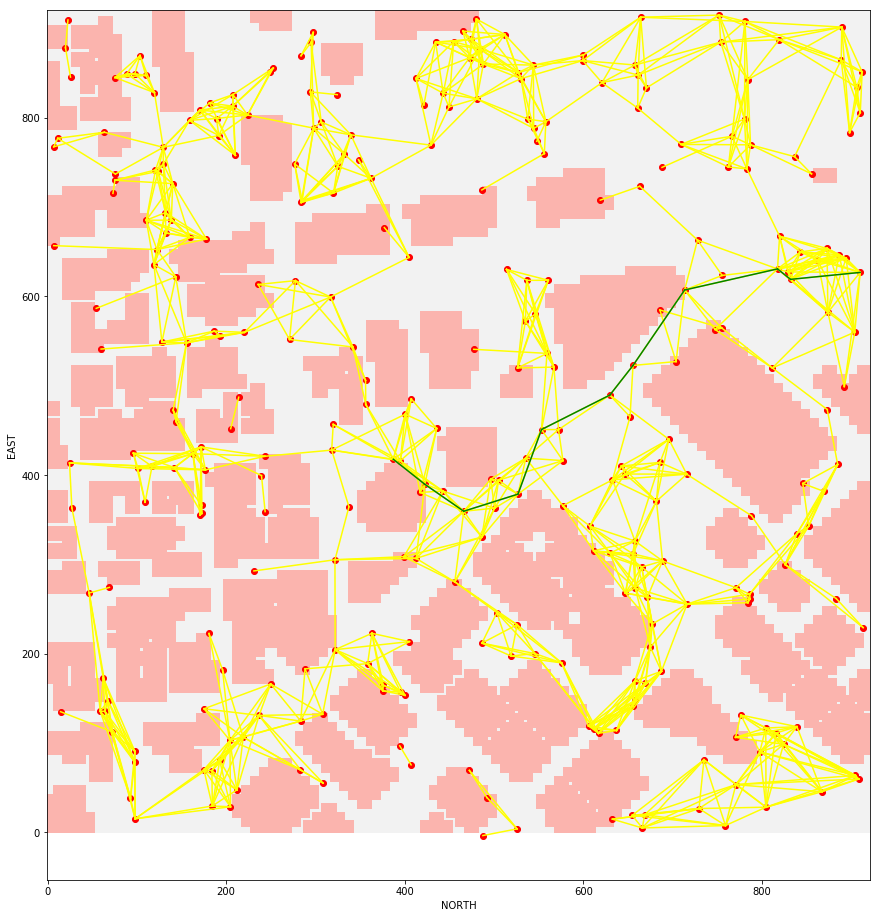

In [50]:
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    print(n1, n2)


# ## Step 7 - Visualize Path

# In[ ]:


fig = plt.figure()

plt.imshow(grid, cmap='Pastel1_r', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# draw nodes
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    
# draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'yellow')
    
# TODO: add code to visualize the path
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'green')


plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()